In [1]:
import pandas as pd #
import numpy as np
from tqdm import tqdm
import random
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction 
smoothie = SmoothingFunction().method4
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import datetime
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable 
import matplotlib.ticker as ticker

In [2]:
class Dataset:
    def __init__(self, data, token_perturbation, token_correct, max_len):
        self.encoder_inps = data['encoder_input'].values
        self.decoder_inps = data['decoder_input'].values
        self.decoder_outs = data['decoder_output'].values
        self.token_correct = token_correct
        self.token_perturbation = token_perturbation
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.token_perturbation.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.token_correct.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.token_correct.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

In [3]:
class Dataloader(tf.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        
        # we are creating data like ([encoder_input, decoder_input], decoder_output) these are already converted into seq
        
        return [batch[0],batch[1]],batch[2]

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [4]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd                           = self.embedding(input_sequence)
        self.lstm_output, self.state_h,self.state_c = self.lstm(input_embedd,initial_state=states)
        return  self.lstm_output, self.state_h,self.state_c

    
    def initialize_states(self,batch_size):
        '''
          Given a batch size it will return intial hidden state and intial cell state.
          If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.state_h=tf.zeros((batch_size,self.lstm_size))
        self.state_c=tf.zeros((batch_size,self.lstm_size))
        return self.state_h,self.state_c

    

In [5]:
class Attention(tf.keras.layers.Layer):
        #Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    
    def __init__(self,scoring_function, att_units):
        super().__init__()
        self.scoring_function=scoring_function
        self.att_units = att_units

    # Please go through the reference notebook and research paper to complete the scoring functions

        if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
            pass
        if scoring_function == 'general':
            self.wn=Dense(att_units)
          # Intialize variables needed for General score function here
        elif scoring_function == 'concat':
            self.w1=Dense(att_units)
            self.w2=Dense(att_units)
            self.V=Dense(1)
          # Intialize variables needed for Concat score function here
  
  
    def call(self,decoder_hidden_state,encoder_output):

      #Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      #* Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
       # Multiply the score function with your encoder_outputs to get the context vector.
        #Function returns context vector and attention weights(softmax - scores)
    
        if self.scoring_function == 'dot':
            query_with_time_axis = tf.expand_dims(decoder_hidden_state,1)         
            score=tf.keras.layers.Dot(axes=2)([encoder_output,query_with_time_axis])                               
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)
        
        elif self.scoring_function == 'general':
            query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1) 
            w=self.wn(query_with_time_axis)                                          
            score=tf.keras.layers.Dot(axes=2)([encoder_output,w])                              
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)
            
        elif self.scoring_function == 'concat':
            query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)  
            score = self.V(tf.nn.tanh(self.w1(encoder_output) + self.w2(query_with_time_axis)))
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

    
    

In [6]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(One_Step_Decoder, self).__init__()
        self.att_units=att_units
        self.score_fun = score_fun
        self.tar_vocab_size=tar_vocab_size
        self.embedding_dim=embedding_dim
        self.input_length=input_length
        self.dec_units=dec_units
        self.att_units = att_units
        self.attention=Attention(self.score_fun,self.att_units)
  
        self.embedding=tf.keras.layers.Embedding(self.tar_vocab_size,output_dim=self.embedding_dim,
                    input_length=self.input_length)
        self.lstm=LSTM(self.dec_units, return_state=True, return_sequences=True)
        self.dense=tf.keras.layers.Dense(self.tar_vocab_size)
        


    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        embed=self.embedding(input_to_decoder)   
        context_vec,weights=self.attention(state_h,encoder_output)
        result=tf.concat([tf.expand_dims(context_vec, axis=1),embed],axis=-1)
        output,h,c=self.lstm(result,initial_state=[state_h,state_c])
        out=tf.reshape(output,(-1,output.shape[-1]))
    
        dense_op=self.dense(out)
    
        return dense_op,h,c,weights,context_vec
        
        
        
        
        
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.onestep=One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        all_outputs=tf.TensorArray(tf.float32,10,name="output_array")
        for step in range(10):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestep(input_to_decoder[:,step:step+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs=all_outputs.write(step,output)
        
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs
          

In [8]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, lstm_size, 
                 input_length, output_length, dec_units ,score_fun ,att_units, batch_size):
        
        super(encoder_decoder, self).__init__()
        
        self.encoder = Encoder(inp_vocab_size, embedding_size, lstm_size, input_length)
        self.decoder = Decoder(out_vocab_size, embedding_size, output_length, 
                               dec_units, score_fun, att_units)
     #Intialize objects from encoder decoder
    def call(self, data):
        
        input_sequence, input_to_decoder = data[0],data[1]
        initial_state = self.encoder.initialize_states(64)
        encoder_output, state_h, state_c = self.encoder(input_sequence, initial_state)
        decoder_hidden_state = state_h
        decoder_cell_state = state_c
        decoder_output = self.decoder(input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state)
        
        return decoder_output
    
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output

In [9]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
optimizer = tf.keras.optimizers.Adam()

In [10]:
def predict(input_sentence,token_perturbation,token_correct,model):
    
    '''
      A. Given input sentence, convert the sentence into integers using tokenizer used earlier
      B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
      C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
      D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
      E. Return the predicted sentence
      '''
    attention_plot = np.zeros((20, 20))
    encoder_inp = input_sentence
    encoder_seq = token_perturbation.texts_to_sequences([encoder_inp])
    encoder_seq = pad_sequences(encoder_seq, maxlen=20, dtype='int32', padding='post')
    inputs = tf.convert_to_tensor(encoder_seq)

    result = ''
    enc_hidden = model.layers[0].initialize_states(1)
    encoder_output,state_h,state_c = model.layers[0](inputs,enc_hidden)

    dec_input = tf.expand_dims([token_correct.word_index['<start>']], 0)

    for t in range(10):
        predictions,state_h,state_c,attention_weights,context_vector = model.layers[1].onestep(dec_input,encoder_output,state_h,state_c)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += token_correct.index_word[predicted_id] + ' '

        if token_correct.index_word[predicted_id] == '<end>':
            return result,attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result,attention_plot

In [33]:
def Prediction(Input):
    
    train = pd.read_csv('Attention_train_final.csv')
    validation = pd.read_csv('Attention_Validation_final.csv')
    
    with open('Attention_concat_final_TP', 'rb') as f:
        token_perturbation = pickle.load(f)
    with open('Attention_concat_final_TC', 'rb') as f:
        token_correct = pickle.load(f)
    v_perturbation = len(token_perturbation.word_index.keys()) +1
    v_correct=len(token_correct.word_index.keys()) +1
    
    train_dataset = Dataset(train, token_perturbation, token_correct, 10)
    test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

    train_dataloader = Dataloader(train_dataset, batch_size=64)
    test_dataloader = Dataloader(test_dataset, batch_size=64)
    
    input_vocab_size = v_perturbation
    output_vocab_size = v_correct

    input_len = 10
    output_len = 10

    lstm_size = 128
    att_units = 128
    dec_units = 128
    embedding_size = 128
    embedding_dim = 128
    score_fun = 'dot'
    batch_size=64

    model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, batch_size)
    model.build(input_shape = [64,64,128])
    model.load_weights('Attention_Dot_3.h5')
    
    predicted_sentence,attention_plot = predict(Input[0],token_perturbation,token_correct,model)
    output_sentence=predicted_sentence.replace('<end>','')
    
    print("The Original Sentence given : {}".format(Input[0]))
    print("The Corrected Sentence is : {}".format(output_sentence))
    
    return predicted_sentence

In [34]:
def Performance_metric(Input):
    Predicted = Prediction(Input)
    
    output_sentence=Input[1].lower()
    output_sentence=output_sentence.replace(".","")
    output_sentence=output_sentence.replace("?","")
    output_sentence=output_sentence.replace("!","")
    output_sentence=output_sentence.replace(",","")
    output_sentence=output_sentence.replace('"','')
    output_sentence=output_sentence.replace('-',' ')
    
    correct = output_sentence.split()
    pred = Predicted.split()
    
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    
    print("The Bleu_score for the correction is {}".format(bleu_score))

In [35]:
test1 = ['They argued that thr earth id round.','They argued that the earth is round. <end>']

In [36]:
Performance_metric(test1)

The Original Sentence given : They argued that thr earth id round.
The Corrected Sentence is : they argued that the earth is round  
The Bleu_score for the correction is 1.0


In [37]:
test2 = ['She said shi wanted to be s teacher.','She said she wanted to be a teacher. <end>']

In [38]:
Performance_metric(test2)

The Original Sentence given : She said shi wanted to be s teacher.
The Corrected Sentence is : she said she wanted to be a teacher  
The Bleu_score for the correction is 1.0


In [39]:
test3 = ['Monday was the busy day for me.','Monday was a busy day for me. <end>']

In [40]:
Performance_metric(test3)

The Original Sentence given : Monday was the busy day for me.
The Corrected Sentence is : monday was a busy day for me  
The Bleu_score for the correction is 1.0


In [41]:
test4 = ['Tom wsd acquitted on thr grounds of temporary insanity.','Tom was acquitted on the grounds of temporary insanity. <end>']

In [42]:
Performance_metric(test4)

The Original Sentence given : Tom wsd acquitted on thr grounds of temporary insanity.
The Corrected Sentence is : tom was acquitted on the grounds of temporary insanity  
The Bleu_score for the correction is 1.0


In [43]:
test5 = ['There are s lot of fish im thr pond.','There are a lot of fish in the pond. <end>']

In [44]:
Performance_metric(test5)

The Original Sentence given : There are s lot of fish im thr pond.
The Corrected Sentence is : there are a lot of fish in the pond  
The Bleu_score for the correction is 1.0


###   Deployment Using Flask API

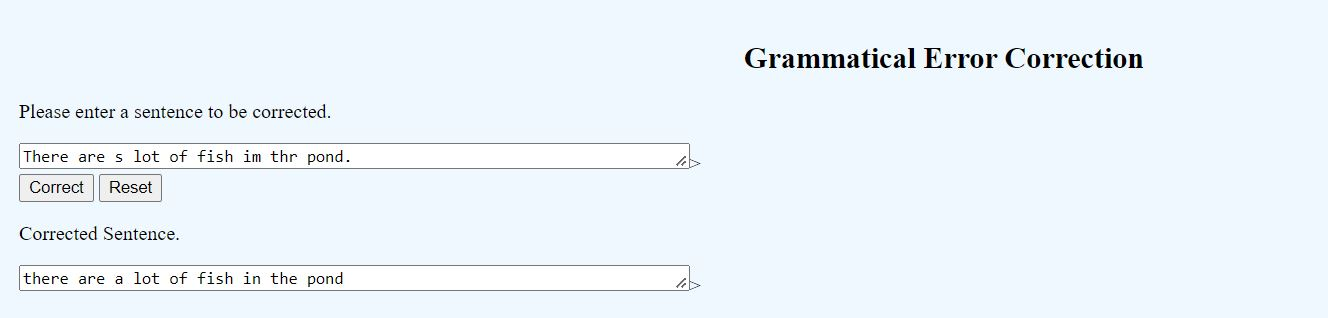

-  We gave Test5 as Input in the above FLask API deployment in our local system, we were able to achieve the same result as here.

### Analysis:

-  We made 2 functions, **Prediction** and **Performance_Metric** to evalute the Data points.
-  We ran this prediction model for 5 randomly selected data points from our dataset.
-  For all the Sample Data points we were able to get a **Bleu_score** of **1**, which means that our model was able to perform quite well.
-  We were able to deploy the same model using **Flask API** in our **Local System** as well as **AWS**. We have added the screenshot for the **HTML** pages. The recorded video of the same is as follows - 
https://drive.google.com/file/d/1UqvjbmFlxV-VotwaeLFdn-xbzhQ15ZrR/view?usp=sharing